# Proposal 1

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.training import CEWCV1
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/proposal_1.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

# Model Selection

In [9]:
from math import floor
from itertools import product
from typing import List

# Constants
MODEL_SELECTION_MAX_EXPERIENCES = floor(N_EXPERIENCES * 0.2)

strategy_hyperparameters_grid = {
    "ewc_lambda_l1": [0.01, 0.1, 1.0, 10.0],
    "ewc_lambda_l2": [0.01, 0.1, 1.0, 10.0],
    "threshold": [1e-5, 1, 10],
}

# Create the models
models = [
    SimpleMLP(num_classes=scenario.n_classes, hidden_size=100, input_size=28 * 28).to(TORCH_DEVICE)
    for _ in product(*strategy_hyperparameters_grid.values())
]
hyperparameters_product = list(product(*strategy_hyperparameters_grid.values()))

strategies: List[CEWCV1] = []
for model, hyperparameters in zip(models, hyperparameters_product):
    strategy = CEWCV1(
        model,
        SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005),
        CrossEntropyLoss(),
        train_mb_size=100,
        train_epochs=1,
        eval_mb_size=100,
        device=TORCH_DEVICE,
        evaluator=EvaluationPlugin(
            accuracy_metrics(
                stream=True
            ),
        ),
        **dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters)),
    )
    strategies.append(strategy)

# train each model on the first 20% of the experiences
for i, strategy in enumerate(strategies):
    print(f"Training model {i + 1}/{len(strategies)}")
    for experience in train_stream[:MODEL_SELECTION_MAX_EXPERIENCES]:
        strategy.train(experience)
    strategy.eval(train_stream[:MODEL_SELECTION_MAX_EXPERIENCES])


Training model 1/48
Training model 2/48
Training model 3/48
Training model 4/48
Training model 5/48
Training model 6/48
Training model 7/48
Training model 8/48
Training model 9/48
Training model 10/48
Training model 11/48
Training model 12/48
Training model 13/48
Training model 14/48
Training model 15/48
Training model 16/48
Training model 17/48
Training model 18/48
Training model 19/48
Training model 20/48
Training model 21/48
Training model 22/48
Training model 23/48
Training model 24/48
Training model 25/48
Training model 26/48
Training model 27/48
Training model 28/48
Training model 29/48
Training model 30/48
Training model 31/48
Training model 32/48
Training model 33/48
Training model 34/48
Training model 35/48
Training model 36/48
Training model 37/48
Training model 38/48
Training model 39/48
Training model 40/48
Training model 41/48
Training model 42/48
Training model 43/48
Training model 44/48
Training model 45/48
Training model 46/48
Training model 47/48
Training model 48/48


In [10]:
# Get the model with the best averaged accuracy
best_hyperparameters_idx = -1
best_avg_accuracy = 0

for i, strategy in enumerate(strategies):
    avg_accuracy = strategy.evaluator.get_last_metrics()["Top1_Acc_Stream/eval_phase/train_stream/Task000"]
    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy
        best_hyperparameters_idx = i

best_hyperparameters = dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters_product[best_hyperparameters_idx]))

In [11]:
best_hyperparameters

{'ewc_lambda_l1': 0.1, 'ewc_lambda_l2': 1.0, 'threshold': 1e-05}

## Evaluation metrics definition

In [12]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [13]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [14]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = CEWCV1(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 102.61it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 119.1000
	Loss_MB/train_phase/train_stream/Task000 = 9.9611
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.5711
100%|██████████| 469/469 [00:04<00:00, 103.20it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 126.3000
	Loss_MB/train_phase/train_stream/Task000 = 15.1188
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.5448
100%|██████████| 469/469 [00:04<00:00, 104.03it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 124.8000
	Loss_MB/train_phase/train_stream/Task000 = 19.4504
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.5087
100%|██████████| 469/469 [00:04<00:00, 103.77it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/trai

 10%|█         | 1/10 [00:36<05:25, 36.13s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.0775
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17e3f89d0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 20%|██        | 2/10 [01:11<04:46, 35.78s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.8959
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x176a75280>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.8936, 0.9262, 0.1365, 0.1022, 0.1619, 0.0721, 0.1205, 0.0945, 0.1201,
         0.1699],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 30%|███       | 3/10 [01:48<04:14, 36.41s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.0897
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x176c48f10>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.8936, 0.9262, 0.1365, 0.1022, 0.1619, 0.0721, 0.1205, 0.0945, 0.1201,
         0.1699],
        [0.8792, 0.8930, 0.9322, 0.0805, 0.1256, 0.1072, 0.0869, 0.1159, 0.1173,
         0.1355],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 40%|████      | 4/10 [02:26<03:42, 37.10s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7595
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x176fb9a30>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.8936, 0.9262, 0.1365, 0.1022, 0.1619, 0.0721, 0.1205, 0.0945, 0.1201,
         0.1699],
        [0.8792, 0.8930, 0.9322, 0.0805, 0.1256, 0.1072, 0.0869, 0.1159, 0.1173,
         0.1355],
        [0.8149, 0.8773, 0.9195, 0.9374, 0.0765, 0.0762, 0.0888, 0.0997, 0.1244,
         0.1263],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 50%|█████     | 5/10 [03:04<03:06, 37.32s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3765
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1775ebdf0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.8936, 0.9262, 0.1365, 0.1022, 0.1619, 0.0721, 0.1205, 0.0945, 0.1201,
         0.1699],
        [0.8792, 0.8930, 0.9322, 0.0805, 0.1256, 0.1072, 0.0869, 0.1159, 0.1173,
         0.1355],
        [0.8149, 0.8773, 0.9195, 0.9374, 0.0765, 0.0762, 0.0888, 0.0997, 0.1244,
         0.1263],
        [0.8034, 0.8518, 0.8978, 0.9151, 0.9376, 0.0887, 0.0900, 0.1084, 0.1322,
         0.1549],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 60%|██████    | 6/10 [03:42<02:30, 37.52s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3389
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17e71f190>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.8936, 0.9262, 0.1365, 0.1022, 0.1619, 0.0721, 0.1205, 0.0945, 0.1201,
         0.1699],
        [0.8792, 0.8930, 0.9322, 0.0805, 0.1256, 0.1072, 0.0869, 0.1159, 0.1173,
         0.1355],
        [0.8149, 0.8773, 0.9195, 0.9374, 0.0765, 0.0762, 0.0888, 0.0997, 0.1244,
         0.1263],
        [0.8034, 0.8518, 0.8978, 0.9151, 0.9376, 0.0887, 0.0900, 0.1084, 0.1322,
         0.1549],
        [0.7381, 0.8068, 0.8755, 0.9064, 0.9213, 0.9387, 0.0971, 0.1347, 0.1084,
         0.1230],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 70%|███████   | 7/10 [04:20<01:53, 37.67s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.1643
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17fbfa880>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.8936, 0.9262, 0.1365, 0.1022, 0.1619, 0.0721, 0.1205, 0.0945, 0.1201,
         0.1699],
        [0.8792, 0.8930, 0.9322, 0.0805, 0.1256, 0.1072, 0.0869, 0.1159, 0.1173,
         0.1355],
        [0.8149, 0.8773, 0.9195, 0.9374, 0.0765, 0.0762, 0.0888, 0.0997, 0.1244,
         0.1263],
        [0.8034, 0.8518, 0.8978, 0.9151, 0.9376, 0.0887, 0.0900, 0.1084, 0.1322,
         0.1549],
        [0.7381, 0.8068, 0.8755, 0.9064, 0.9213, 0.9387, 0.0971, 0.1347, 0.1084,
         0.1230],
        [0.6788, 0.7415, 0.8070, 0.8828, 0.8794, 0.9177, 0.9417, 0.1341, 0.1145,
         0.1514],
    

 80%|████████  | 8/10 [04:59<01:16, 38.12s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4226
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17ff26130>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.8936, 0.9262, 0.1365, 0.1022, 0.1619, 0.0721, 0.1205, 0.0945, 0.1201,
         0.1699],
        [0.8792, 0.8930, 0.9322, 0.0805, 0.1256, 0.1072, 0.0869, 0.1159, 0.1173,
         0.1355],
        [0.8149, 0.8773, 0.9195, 0.9374, 0.0765, 0.0762, 0.0888, 0.0997, 0.1244,
         0.1263],
        [0.8034, 0.8518, 0.8978, 0.9151, 0.9376, 0.0887, 0.0900, 0.1084, 0.1322,
         0.1549],
        [0.7381, 0.8068, 0.8755, 0.9064, 0.9213, 0.9387, 0.0971, 0.1347, 0.1084,
         0.1230],
        [0.6788, 0.7415, 0.8070, 0.8828, 0.8794, 0.9177, 0.9417, 0.1341, 0.1145,
         0.1514],
    

 90%|█████████ | 9/10 [05:37<00:38, 38.04s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.9601
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x28abd1250>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.8936, 0.9262, 0.1365, 0.1022, 0.1619, 0.0721, 0.1205, 0.0945, 0.1201,
         0.1699],
        [0.8792, 0.8930, 0.9322, 0.0805, 0.1256, 0.1072, 0.0869, 0.1159, 0.1173,
         0.1355],
        [0.8149, 0.8773, 0.9195, 0.9374, 0.0765, 0.0762, 0.0888, 0.0997, 0.1244,
         0.1263],
        [0.8034, 0.8518, 0.8978, 0.9151, 0.9376, 0.0887, 0.0900, 0.1084, 0.1322,
         0.1549],
        [0.7381, 0.8068, 0.8755, 0.9064, 0.9213, 0.9387, 0.0971, 0.1347, 0.1084,
         0.1230],
        [0.6788, 0.7415, 0.8070, 0.8828, 0.8794, 0.9177, 0.9417, 0.1341, 0.1145,
         0.1514],
    

100%|██████████| 10/10 [06:15<00:00, 37.55s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3711
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x28afb26a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2163.2061
	EvalStream/Acc_Matrix = 
tensor([[0.9104, 0.1037, 0.1308, 0.1108, 0.1235, 0.0931, 0.1533, 0.1226, 0.1153,
         0.1692],
        [0.8936, 0.9262, 0.1365, 0.1022, 0.1619, 0.0721, 0.1205, 0.0945, 0.1201,
         0.1699],
        [0.8792, 0.8930, 0.9322, 0.0805, 0.1256, 0.1072, 0.0869, 0.1159, 0.1173,
         0.1355],
        [0.8149, 0.8773, 0.9195, 0.9374, 0.0765, 0.0762, 0.0888, 0.0997, 0.1244,
         0.1263],
        [0.8034, 0.8518, 0.8978, 0.9151, 0.9376, 0.0887, 0.0900, 0.1084, 0.1322,
         0.1549],
        [0.7381, 0.8068, 0.8755, 0.9064, 0.9213, 0.9387, 0.0971, 0.1347, 0.1084,
         0.1230],
        [0.6788, 0.7415, 0.8070, 0.8828, 0.8794, 0.9177, 0.9417, 0.1341, 0.1145,
         0.1514],
    

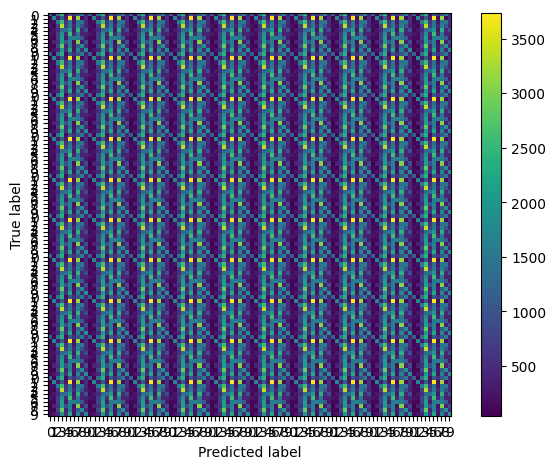

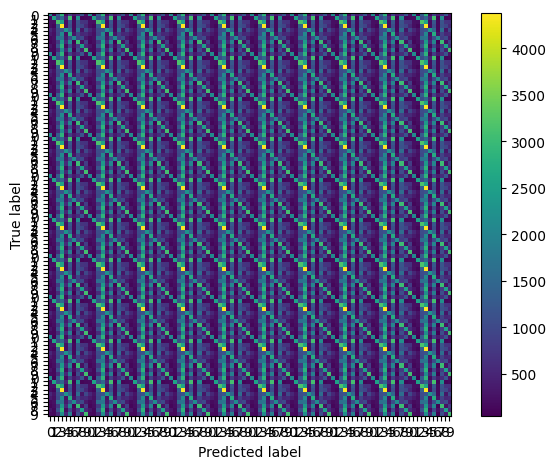

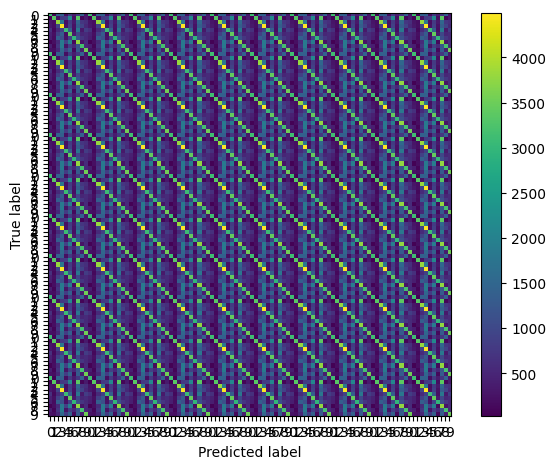

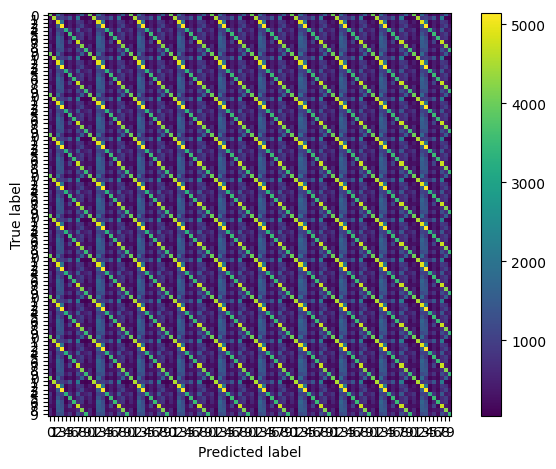

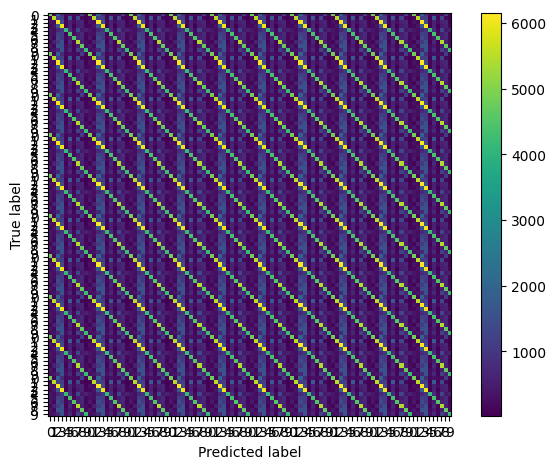

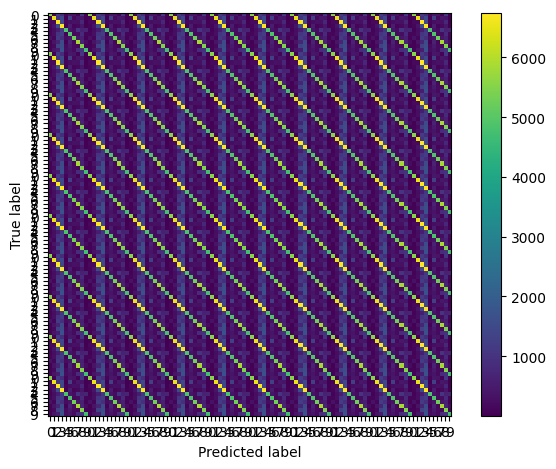

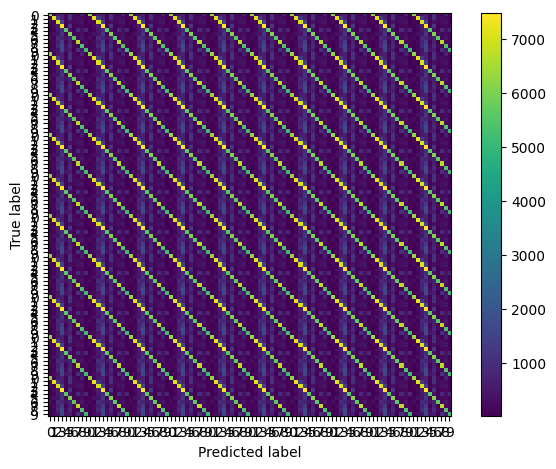

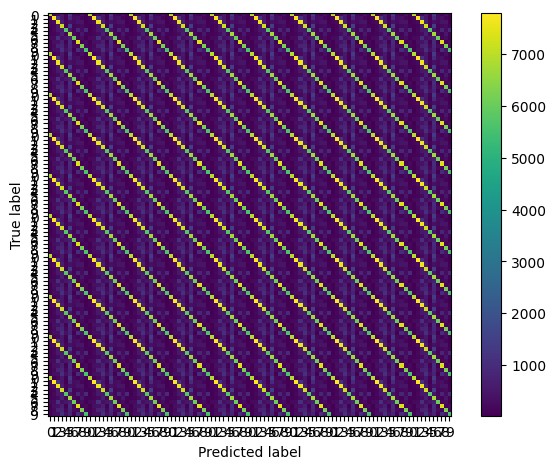

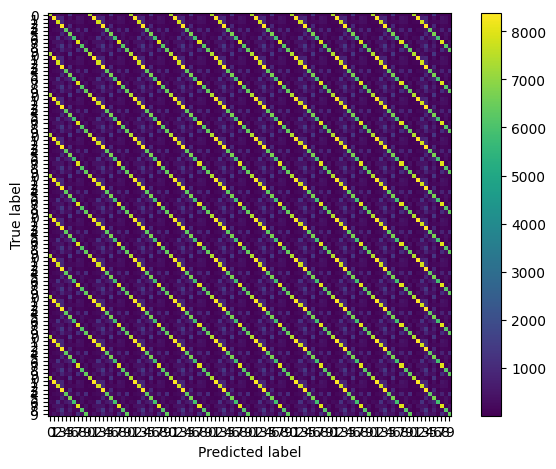

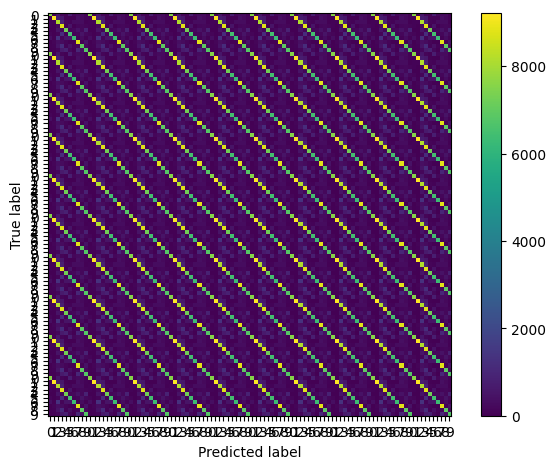

In [15]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [16]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [17]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [18]:
all_loss_components = strategy.get_store_loss()

In [19]:
weights = model_plugins[0].weights

# Store metrics

In [20]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "all_loss_components": all_loss_components,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))